Test the performence of deep-ae

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [1]:
import numpy as np
import pandas as pd

import pickle
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Input, Dense
from keras.models import Model
import keras

from sklearn import preprocessing
import seaborn as sns

Using TensorFlow backend.


Globals

In [3]:
early_stopping_monitor = keras.callbacks.EarlyStopping(monitor='acc', patience=50, verbose=1)

Load data

In [4]:
pklfile = '../data/breast_bands.pkl'
with open(pklfile, 'rb') as fi:
    feat_breast = pickle.load(fi)
    
pklfile = '../data/ovary_bands.pkl'
with open(pklfile, 'rb') as fi:
    feat_ovary = pickle.load(fi)
    
pklfile = '../data/skin_bands.pkl'
with open(pklfile, 'rb') as fi:
    feat_skin = pickle.load(fi)

pklfile = '../data/sob_bands.pkl'
with open(pklfile, 'rb') as fi:
    feat_sob = pickle.load(fi)

Scaling data to [0,1]

In [5]:
feat_breast = preprocessing.MinMaxScaler().fit_transform(np.abs(feat_breast))
feat_ovary = preprocessing.MinMaxScaler().fit_transform(np.abs(feat_ovary))
feat_skin = preprocessing.MinMaxScaler().fit_transform(np.abs(feat_skin))
feat_sob = preprocessing.MinMaxScaler().fit_transform(np.abs(feat_sob))

### Models

Basic Model

In [6]:
def basic_dae(feat_mat, noise_factor=0.05, hidden_size=800, batch_size=128, epochs=2000):
    
    input_size = feat_mat.shape[1]
    feat_noisy = feat_mat + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=feat_mat.shape) 
    feat_noisy = np.clip(feat_noisy, 0., 1.)

    x = Input(shape=(input_size,))
    h = Dense(hidden_size, activation='relu')(x)
    r = Dense(input_size, activation='sigmoid')(h)

    dae = Model(inputs=x, outputs=r)
    dae.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

    history_base = dae.fit(feat_noisy, feat_noisy, batch_size=batch_size,epochs=epochs, callbacks = [early_stopping_monitor])
    encoder = Model(x,h)
    return dae, encoder

Deep DAE

In [7]:
def deep_dae(feat_mat, noise_factor=0.05, layers=2, start_size=1024, batch_size=128, epochs=2000):
    
    input_size = feat_mat.shape[1]
    feat_noisy = feat_mat + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=feat_mat.shape) 
    feat_noisy = np.clip(feat_noisy, 0., 1.)

    x = Input(shape=(input_size,))
    # First hidden encoder layer
    hidden_encoders = Dense(start_size, activation='relu')(x)
    
    # Adding more layers
    for i in range(1,layers):
        layer_size = int(start_size/(2**i))
        hidden_encoders = Dense(layer_size, activation='relu')(hidden_encoders)
        
    # First hidden decoder layer
    hidden_decoder = Dense(int(start_size/(2**(layers-2))), activation='relu')(hidden_encoders)
    
    # Adding more layers
    for i in range(layers-3,-1,-1):
        layer_size = int(start_size/(2**i))
        hidden_decoder = Dense(layer_size, activation='relu')(hidden_decoder)
    
    r = Dense(input_size, activation='sigmoid')(hidden_decoder)

    dae = Model(inputs=x, outputs=r)
    dae.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

    history_base = dae.fit(feat_noisy, feat_noisy, batch_size=batch_size,epochs=epochs, callbacks = [early_stopping_monitor])
    encoder = Model(x,hidden_encoders)
    return dae, encoder

### Compare depth

Settings

In [8]:
def depth_test(feat_mat):
    
    models = []
    labels = ['basic', 'layers_2', 'layers_3', 'layers_4', 'layers_5', 'layers_4_exp', 'layers_5_exp']
    
    models.append(basic_dae(feat_mat))
    models.append(deep_dae(feat_mat, layers=2))
    models.append(deep_dae(feat_mat, layers=3))
    models.append(deep_dae(feat_mat, layers=4))
    models.append(deep_dae(feat_mat, layers=5))
    models.append(deep_dae(feat_mat, layers=4, start_size=2048))
    models.append(deep_dae(feat_mat, layers=5, start_size=2048))
    
    return models, labels

Plot function

In [9]:
def plotHis(his_list, labels, loss_y_top=0):
    plt.figure(figsize=(40,20))

    plt.subplot(1,2, 1)
    for his in his_list:
        plt.plot(his.history['loss'])
    plt.title('Models loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    if loss_y_top > 0:
        plt.ylim(top=loss_y_top)
    plt.legend(labels, loc='upper right')

    plt.subplot(1,2, 2)
    for his in his_list:
        plt.plot(his.history['acc'])
    plt.title('Models accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(labels, loc='upper right')

    plt.show()

Breast

In [10]:
models_breast, labels_breast = depth_test(feat_breast)







Epoch 1/2000
6250/6250 [==============================] - 2s 267us/step - loss: 0.0332 - acc: 0.0011
Epoch 2/2000
6250/6250 [==============================] - 0s 40us/step - loss: 0.0091 - acc: 0.0026
Epoch 3/2000
6250/6250 [==============================] - 0s 36us/step - loss: 0.0091 - acc: 0.0038
Epoch 4/2000
6250/6250 [==============================] - 0s 36us/step - loss: 0.0090 - acc: 0.0022
Epoch 5/2000
6250/6250 [==============================] - 0s 36us/step - loss: 0.0090 - acc: 0.0032
Epoch 6/2000
6250/6250 [==============================] - 0s 36us/step - loss: 0.0089 - acc: 0.0032
Epoch 7/2000
6250/6250 [==============================] - 0s 36us/step - loss: 0.0088 - acc: 0.0013
Epoch 8/2000
6250/6250 [==============================] - 0s 36us/step - loss: 0.0086 - acc: 0.0019
Epoch 9/2000
6250/6250 [==============================] - 0s 36us/step - loss: 0.0085 - acc: 0.0029
Epoch 10/2000
6250/6250 [==============================] - 0s 36us/step - loss: 0.0083 - acc:

6250/6250 [==============================] - 0s 36us/step - loss: 9.9442e-04 - acc: 0.6342
Epoch 150/2000
6250/6250 [==============================] - 0s 36us/step - loss: 0.0010 - acc: 0.6376
Epoch 151/2000
6250/6250 [==============================] - 0s 36us/step - loss: 9.9871e-04 - acc: 0.6432
Epoch 152/2000
6250/6250 [==============================] - 0s 36us/step - loss: 9.9922e-04 - acc: 0.6507
Epoch 153/2000
6250/6250 [==============================] - 0s 36us/step - loss: 9.8247e-04 - acc: 0.6496
Epoch 154/2000
6250/6250 [==============================] - 0s 36us/step - loss: 9.7325e-04 - acc: 0.6541
Epoch 155/2000
6250/6250 [==============================] - 0s 36us/step - loss: 9.6237e-04 - acc: 0.6554
Epoch 156/2000
6250/6250 [==============================] - 0s 36us/step - loss: 9.5938e-04 - acc: 0.6498
Epoch 157/2000
6250/6250 [==============================] - 0s 36us/step - loss: 9.6118e-04 - acc: 0.6565
Epoch 158/2000
6250/6250 [==============================] - 0s 36

6250/6250 [==============================] - 0s 36us/step - loss: 6.8998e-04 - acc: 0.7683
Epoch 304/2000
6250/6250 [==============================] - 0s 36us/step - loss: 6.8845e-04 - acc: 0.7579
Epoch 305/2000
6250/6250 [==============================] - 0s 36us/step - loss: 6.8167e-04 - acc: 0.7590
Epoch 306/2000
6250/6250 [==============================] - 0s 36us/step - loss: 6.8457e-04 - acc: 0.7622
Epoch 307/2000
6250/6250 [==============================] - 0s 36us/step - loss: 6.9099e-04 - acc: 0.7595
Epoch 308/2000
6250/6250 [==============================] - 0s 36us/step - loss: 6.9760e-04 - acc: 0.7574
Epoch 309/2000
6250/6250 [==============================] - 0s 36us/step - loss: 6.8929e-04 - acc: 0.7557
Epoch 310/2000
6250/6250 [==============================] - 0s 36us/step - loss: 6.8176e-04 - acc: 0.7568
Epoch 311/2000
6250/6250 [==============================] - 0s 36us/step - loss: 6.7412e-04 - acc: 0.7678
Epoch 312/2000
6250/6250 [==============================] - 0

6250/6250 [==============================] - 0s 47us/step - loss: 0.0091 - acc: 0.0011
Epoch 14/2000
6250/6250 [==============================] - 0s 47us/step - loss: 0.0091 - acc: 0.0011
Epoch 15/2000
6250/6250 [==============================] - 0s 47us/step - loss: 0.0091 - acc: 0.0011
Epoch 16/2000
6250/6250 [==============================] - 0s 47us/step - loss: 0.0091 - acc: 0.0011
Epoch 17/2000
6250/6250 [==============================] - 0s 48us/step - loss: 0.0091 - acc: 0.0011
Epoch 18/2000
6250/6250 [==============================] - 0s 48us/step - loss: 0.0091 - acc: 0.0011
Epoch 19/2000
6250/6250 [==============================] - 0s 48us/step - loss: 0.0091 - acc: 0.0011
Epoch 20/2000
6250/6250 [==============================] - 0s 48us/step - loss: 0.0091 - acc: 0.0011
Epoch 21/2000
6250/6250 [==============================] - 0s 48us/step - loss: 0.0091 - acc: 0.0011
Epoch 22/2000
6250/6250 [==============================] - 0s 47us/step - loss: 0.0091 - acc: 0.0011
Epoc

6250/6250 [==============================] - 0s 57us/step - loss: 0.0091 - acc: 0.0011
Epoch 3/2000
6250/6250 [==============================] - 0s 56us/step - loss: 0.0091 - acc: 0.0011
Epoch 4/2000
6250/6250 [==============================] - 0s 56us/step - loss: 0.0091 - acc: 0.0011
Epoch 5/2000
6250/6250 [==============================] - 0s 56us/step - loss: 0.0091 - acc: 0.0011
Epoch 6/2000
6250/6250 [==============================] - 0s 56us/step - loss: 0.0091 - acc: 0.0011
Epoch 7/2000
6250/6250 [==============================] - 0s 56us/step - loss: 0.0091 - acc: 0.0011
Epoch 8/2000
6250/6250 [==============================] - 0s 56us/step - loss: 0.0091 - acc: 0.0011
Epoch 9/2000
6250/6250 [==============================] - 0s 56us/step - loss: 0.0091 - acc: 0.0011
Epoch 10/2000
6250/6250 [==============================] - 0s 56us/step - loss: 0.0091 - acc: 0.0011
Epoch 11/2000
6250/6250 [==============================] - 0s 56us/step - loss: 0.0091 - acc: 0.0011
Epoch 12/20

6250/6250 [==============================] - 1s 103us/step - loss: 0.0091 - acc: 0.0013
Epoch 41/2000
6250/6250 [==============================] - 1s 103us/step - loss: 0.0091 - acc: 0.0013
Epoch 42/2000
6250/6250 [==============================] - 1s 103us/step - loss: 0.0091 - acc: 0.0013
Epoch 43/2000
6250/6250 [==============================] - 1s 103us/step - loss: 0.0091 - acc: 0.0013
Epoch 44/2000
6250/6250 [==============================] - 1s 103us/step - loss: 0.0091 - acc: 0.0013
Epoch 45/2000
6250/6250 [==============================] - 1s 103us/step - loss: 0.0091 - acc: 0.0013
Epoch 46/2000
6250/6250 [==============================] - 1s 103us/step - loss: 0.0091 - acc: 0.0013
Epoch 47/2000
6250/6250 [==============================] - 1s 103us/step - loss: 0.0091 - acc: 0.0013
Epoch 48/2000
6250/6250 [==============================] - 1s 102us/step - loss: 0.0091 - acc: 0.0013
Epoch 49/2000
6250/6250 [==============================] - 1s 102us/step - loss: 0.0091 - acc: 0

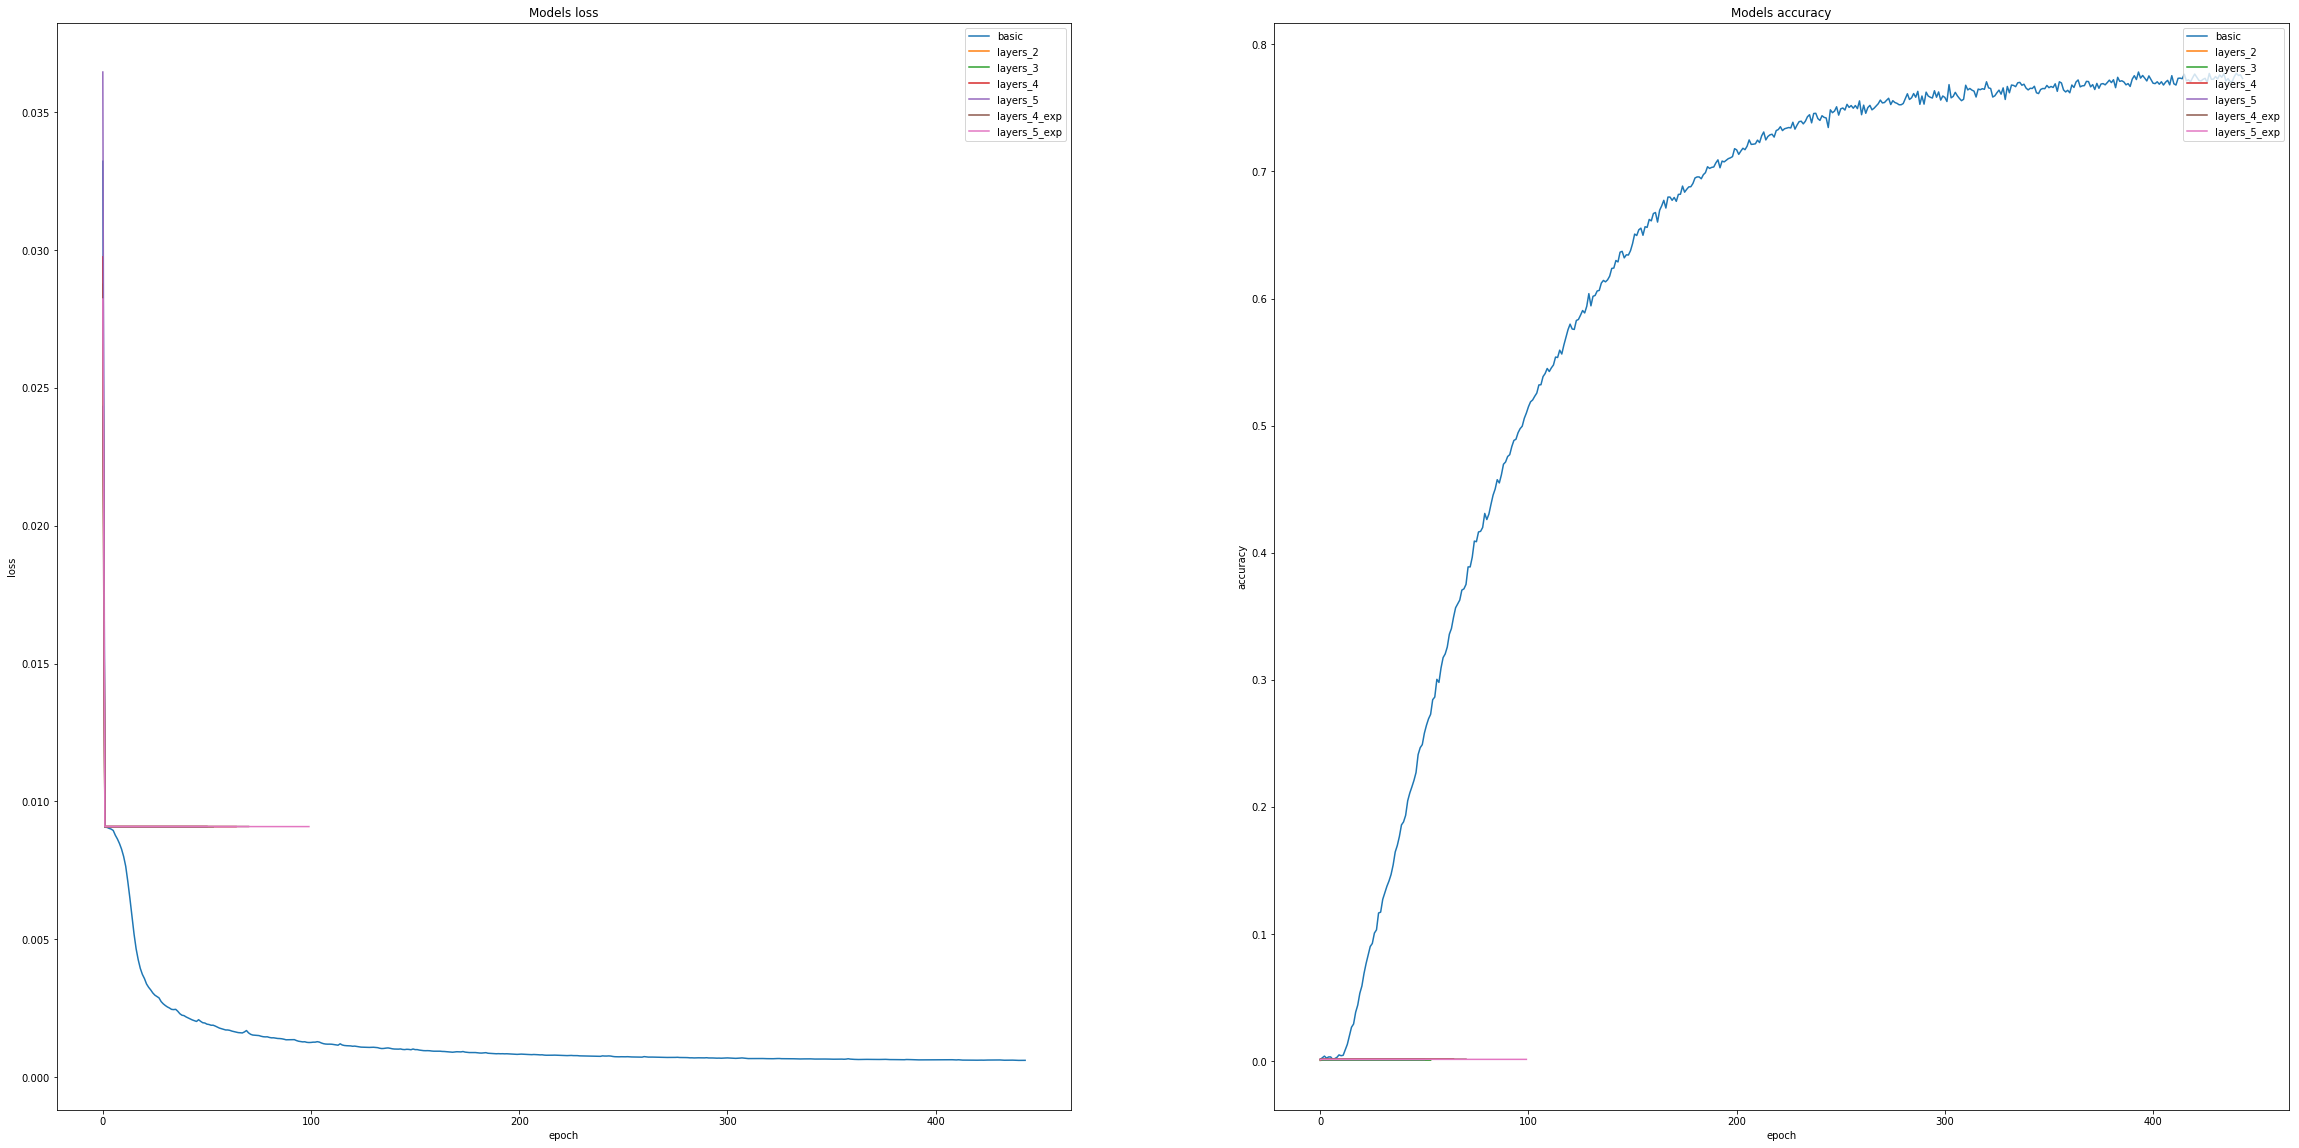

In [11]:
his_breast = [x[0].history for x in models_breast]
plotHis(his_breast, labels_breast)

Ovary

In [12]:
models_ovary, labels_ovary = depth_test(feat_ovary)

Epoch 1/2000
2148/2148 [==============================] - 1s 313us/step - loss: 0.0753 - acc: 0.0023
Epoch 2/2000
2148/2148 [==============================] - 0s 46us/step - loss: 0.0167 - acc: 0.0074
Epoch 3/2000
2148/2148 [==============================] - 0s 41us/step - loss: 0.0167 - acc: 0.0074
Epoch 4/2000
2148/2148 [==============================] - 0s 41us/step - loss: 0.0168 - acc: 0.0074
Epoch 5/2000
2148/2148 [==============================] - 0s 38us/step - loss: 0.0167 - acc: 0.0074
Epoch 6/2000
2148/2148 [==============================] - 0s 38us/step - loss: 0.0167 - acc: 0.0070
Epoch 7/2000
2148/2148 [==============================] - 0s 38us/step - loss: 0.0167 - acc: 0.0056
Epoch 8/2000
2148/2148 [==============================] - 0s 37us/step - loss: 0.0167 - acc: 0.0112
Epoch 9/2000
2148/2148 [==============================] - 0s 37us/step - loss: 0.0167 - acc: 0.0088
Epoch 10/2000
2148/2148 [==============================] - 0s 37us/step - loss: 0.0166 - acc: 0.010

2148/2148 [==============================] - 0s 37us/step - loss: 0.0017 - acc: 0.4269
Epoch 163/2000
2148/2148 [==============================] - 0s 37us/step - loss: 0.0017 - acc: 0.4195
Epoch 164/2000
2148/2148 [==============================] - 0s 37us/step - loss: 0.0016 - acc: 0.4320
Epoch 165/2000
2148/2148 [==============================] - 0s 37us/step - loss: 0.0016 - acc: 0.4334
Epoch 166/2000
2148/2148 [==============================] - 0s 37us/step - loss: 0.0016 - acc: 0.4381
Epoch 167/2000
2148/2148 [==============================] - 0s 37us/step - loss: 0.0016 - acc: 0.4311
Epoch 168/2000
2148/2148 [==============================] - 0s 37us/step - loss: 0.0016 - acc: 0.4372
Epoch 169/2000
2148/2148 [==============================] - 0s 37us/step - loss: 0.0017 - acc: 0.4413
Epoch 170/2000
2148/2148 [==============================] - 0s 37us/step - loss: 0.0017 - acc: 0.4362
Epoch 171/2000
2148/2148 [==============================] - 0s 37us/step - loss: 0.0017 - acc: 0.

2148/2148 [==============================] - 0s 37us/step - loss: 0.0010 - acc: 0.6308
Epoch 323/2000
2148/2148 [==============================] - 0s 38us/step - loss: 0.0010 - acc: 0.6373
Epoch 324/2000
2148/2148 [==============================] - 0s 38us/step - loss: 0.0010 - acc: 0.6350
Epoch 325/2000
2148/2148 [==============================] - 0s 38us/step - loss: 0.0010 - acc: 0.6355
Epoch 326/2000
2148/2148 [==============================] - 0s 37us/step - loss: 0.0010 - acc: 0.6397
Epoch 327/2000
2148/2148 [==============================] - 0s 37us/step - loss: 0.0010 - acc: 0.6359
Epoch 328/2000
2148/2148 [==============================] - 0s 37us/step - loss: 9.7492e-04 - acc: 0.6434
Epoch 329/2000
2148/2148 [==============================] - 0s 37us/step - loss: 9.5889e-04 - acc: 0.6429
Epoch 330/2000
2148/2148 [==============================] - 0s 37us/step - loss: 9.5081e-04 - acc: 0.6480
Epoch 331/2000
2148/2148 [==============================] - 0s 37us/step - loss: 9.44

2148/2148 [==============================] - 0s 37us/step - loss: 7.1978e-04 - acc: 0.7211
Epoch 477/2000
2148/2148 [==============================] - 0s 37us/step - loss: 7.2625e-04 - acc: 0.7193
Epoch 478/2000
2148/2148 [==============================] - 0s 37us/step - loss: 7.4320e-04 - acc: 0.7188
Epoch 479/2000
2148/2148 [==============================] - 0s 37us/step - loss: 7.3840e-04 - acc: 0.7211
Epoch 480/2000
2148/2148 [==============================] - 0s 37us/step - loss: 7.2885e-04 - acc: 0.7239
Epoch 481/2000
2148/2148 [==============================] - 0s 37us/step - loss: 7.2592e-04 - acc: 0.7286
Epoch 482/2000
2148/2148 [==============================] - 0s 37us/step - loss: 7.2239e-04 - acc: 0.7221
Epoch 483/2000
2148/2148 [==============================] - 0s 37us/step - loss: 7.1272e-04 - acc: 0.7332
Epoch 484/2000
2148/2148 [==============================] - 0s 37us/step - loss: 7.0105e-04 - acc: 0.7286
Epoch 485/2000
2148/2148 [==============================] - 0

2148/2148 [==============================] - 0s 37us/step - loss: 6.0984e-04 - acc: 0.7500
Epoch 631/2000
2148/2148 [==============================] - 0s 37us/step - loss: 6.3530e-04 - acc: 0.7467
Epoch 632/2000
2148/2148 [==============================] - 0s 37us/step - loss: 6.3917e-04 - acc: 0.7500
Epoch 633/2000
2148/2148 [==============================] - 0s 37us/step - loss: 6.0718e-04 - acc: 0.7523
Epoch 634/2000
2148/2148 [==============================] - 0s 37us/step - loss: 5.9391e-04 - acc: 0.7570
Epoch 635/2000
2148/2148 [==============================] - 0s 37us/step - loss: 5.8214e-04 - acc: 0.7547
Epoch 636/2000
2148/2148 [==============================] - 0s 38us/step - loss: 5.8009e-04 - acc: 0.7714
Epoch 637/2000
2148/2148 [==============================] - 0s 38us/step - loss: 5.7623e-04 - acc: 0.7584
Epoch 638/2000
2148/2148 [==============================] - 0s 38us/step - loss: 5.7118e-04 - acc: 0.7607
Epoch 639/2000
2148/2148 [==============================] - 0

2148/2148 [==============================] - 0s 37us/step - loss: 4.8638e-04 - acc: 0.7747
Epoch 785/2000
2148/2148 [==============================] - 0s 38us/step - loss: 4.8245e-04 - acc: 0.7765
Epoch 786/2000
2148/2148 [==============================] - 0s 37us/step - loss: 4.8344e-04 - acc: 0.7742
Epoch 787/2000
2148/2148 [==============================] - 0s 37us/step - loss: 4.7861e-04 - acc: 0.7784
Epoch 788/2000
2148/2148 [==============================] - 0s 37us/step - loss: 4.8073e-04 - acc: 0.7765
Epoch 00788: early stopping
Epoch 1/2000
2148/2148 [==============================] - 1s 388us/step - loss: 0.0591 - acc: 0.0000e+00
Epoch 2/2000
2148/2148 [==============================] - 0s 49us/step - loss: 0.0168 - acc: 0.0019
Epoch 3/2000
2148/2148 [==============================] - 0s 49us/step - loss: 0.0168 - acc: 0.0019
Epoch 4/2000
2148/2148 [==============================] - 0s 49us/step - loss: 0.0168 - acc: 0.0019
Epoch 5/2000
2148/2148 [============================

2148/2148 [==============================] - 1s 642us/step - loss: 0.0827 - acc: 0.0000e+00
Epoch 2/2000
2148/2148 [==============================] - 0s 75us/step - loss: 0.0168 - acc: 0.0028
Epoch 3/2000
2148/2148 [==============================] - 0s 63us/step - loss: 0.0168 - acc: 0.0028
Epoch 4/2000
2148/2148 [==============================] - 0s 60us/step - loss: 0.0168 - acc: 0.0028
Epoch 5/2000
2148/2148 [==============================] - 0s 58us/step - loss: 0.0168 - acc: 0.0028
Epoch 6/2000
2148/2148 [==============================] - 0s 58us/step - loss: 0.0168 - acc: 0.0028
Epoch 7/2000
2148/2148 [==============================] - 0s 58us/step - loss: 0.0168 - acc: 0.0028
Epoch 8/2000
2148/2148 [==============================] - 0s 58us/step - loss: 0.0168 - acc: 0.0028
Epoch 9/2000
2148/2148 [==============================] - 0s 58us/step - loss: 0.0168 - acc: 0.0028
Epoch 10/2000
2148/2148 [==============================] - 0s 58us/step - loss: 0.0168 - acc: 0.0028
Epoch 1

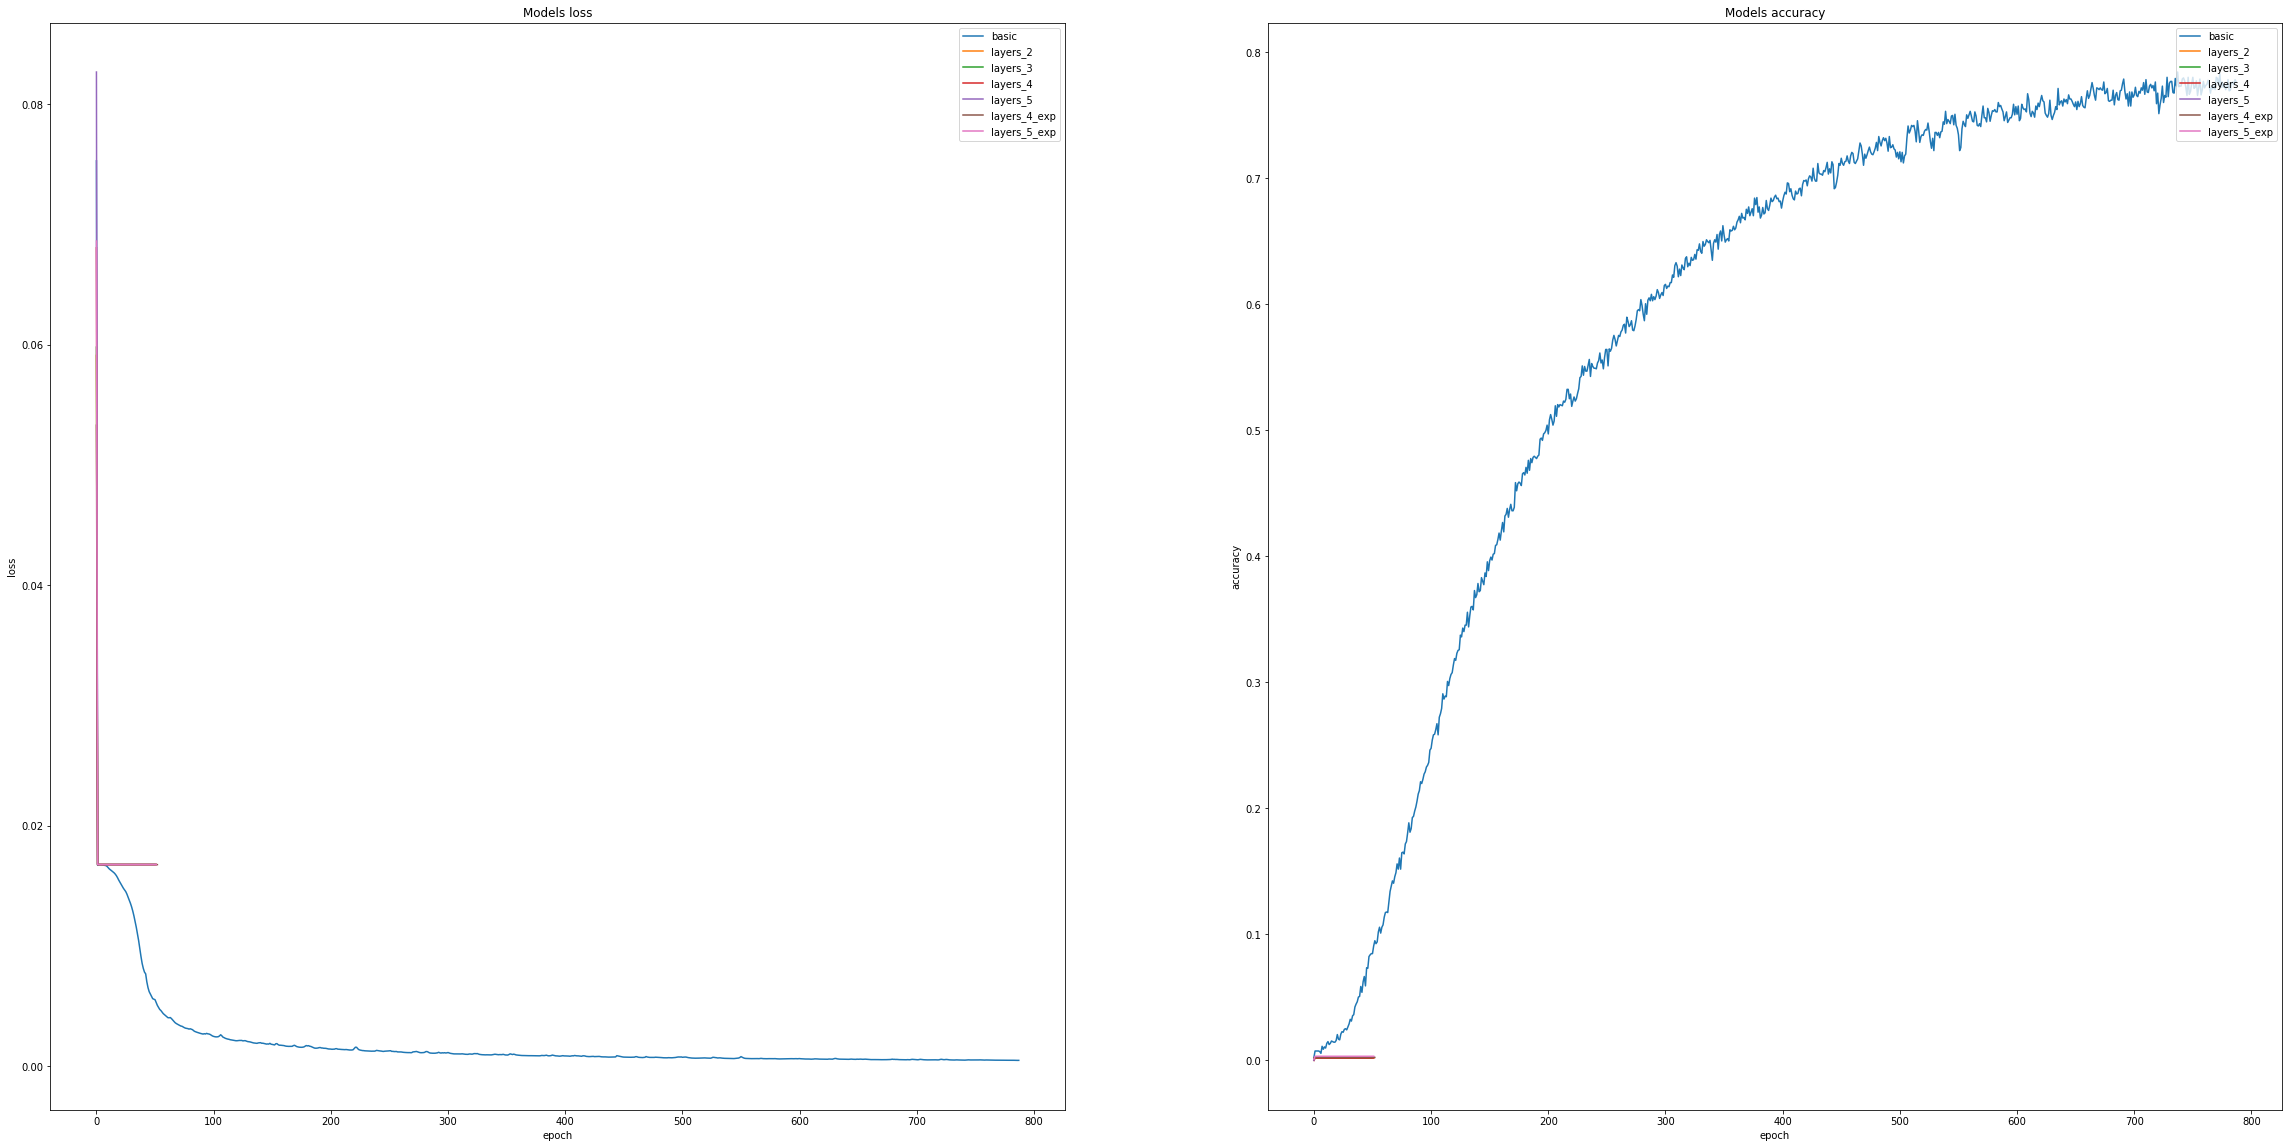

In [13]:
his_ovary = [x[0].history for x in models_ovary]
plotHis(his_ovary, labels_ovary)

Skin

In [14]:
models_skin, labels_skin = depth_test(feat_skin)

Epoch 1/2000
1238/1238 [==============================] - 1s 879us/step - loss: 0.1124 - acc: 0.0000e+00
Epoch 2/2000
1238/1238 [==============================] - 0s 48us/step - loss: 0.0175 - acc: 0.0000e+00
Epoch 3/2000
1238/1238 [==============================] - 0s 47us/step - loss: 0.0170 - acc: 0.0057
Epoch 4/2000
1238/1238 [==============================] - 0s 46us/step - loss: 0.0171 - acc: 0.0065
Epoch 5/2000
1238/1238 [==============================] - 0s 46us/step - loss: 0.0171 - acc: 0.0065
Epoch 6/2000
1238/1238 [==============================] - 0s 46us/step - loss: 0.0171 - acc: 0.0073
Epoch 7/2000
1238/1238 [==============================] - 0s 42us/step - loss: 0.0171 - acc: 0.0073
Epoch 8/2000
1238/1238 [==============================] - 0s 42us/step - loss: 0.0171 - acc: 0.0073
Epoch 9/2000
1238/1238 [==============================] - 0s 42us/step - loss: 0.0171 - acc: 0.0073
Epoch 10/2000
1238/1238 [==============================] - 0s 41us/step - loss: 0.0171 - ac

1238/1238 [==============================] - 0s 39us/step - loss: 0.0038 - acc: 0.1010
Epoch 83/2000
1238/1238 [==============================] - 0s 39us/step - loss: 0.0037 - acc: 0.1026
Epoch 84/2000
1238/1238 [==============================] - 0s 39us/step - loss: 0.0036 - acc: 0.1163
Epoch 85/2000
1238/1238 [==============================] - 0s 39us/step - loss: 0.0035 - acc: 0.1123
Epoch 86/2000
1238/1238 [==============================] - 0s 39us/step - loss: 0.0035 - acc: 0.1050
Epoch 87/2000
1238/1238 [==============================] - 0s 39us/step - loss: 0.0034 - acc: 0.1066
Epoch 88/2000
1238/1238 [==============================] - 0s 39us/step - loss: 0.0034 - acc: 0.1147
Epoch 89/2000
1238/1238 [==============================] - 0s 39us/step - loss: 0.0033 - acc: 0.1123
Epoch 90/2000
1238/1238 [==============================] - 0s 39us/step - loss: 0.0033 - acc: 0.1204
Epoch 91/2000
1238/1238 [==============================] - 0s 39us/step - loss: 0.0032 - acc: 0.1228
Epoc

1238/1238 [==============================] - 0s 39us/step - loss: 0.0014 - acc: 0.4588
Epoch 243/2000
1238/1238 [==============================] - 0s 39us/step - loss: 0.0013 - acc: 0.4604
Epoch 244/2000
1238/1238 [==============================] - 0s 39us/step - loss: 0.0013 - acc: 0.4523
Epoch 245/2000
1238/1238 [==============================] - 0s 39us/step - loss: 0.0013 - acc: 0.4612
Epoch 246/2000
1238/1238 [==============================] - 0s 39us/step - loss: 0.0013 - acc: 0.4620
Epoch 247/2000
1238/1238 [==============================] - 0s 39us/step - loss: 0.0013 - acc: 0.4669
Epoch 248/2000
1238/1238 [==============================] - 0s 39us/step - loss: 0.0013 - acc: 0.4628
Epoch 249/2000
1238/1238 [==============================] - 0s 39us/step - loss: 0.0014 - acc: 0.4637
Epoch 250/2000
1238/1238 [==============================] - 0s 39us/step - loss: 0.0014 - acc: 0.4661
Epoch 251/2000
1238/1238 [==============================] - 0s 39us/step - loss: 0.0015 - acc: 0.

1238/1238 [==============================] - 0s 39us/step - loss: 9.2478e-04 - acc: 0.6228
Epoch 402/2000
1238/1238 [==============================] - 0s 39us/step - loss: 9.1817e-04 - acc: 0.6204
Epoch 403/2000
1238/1238 [==============================] - 0s 39us/step - loss: 9.1247e-04 - acc: 0.6212
Epoch 404/2000
1238/1238 [==============================] - 0s 39us/step - loss: 9.0721e-04 - acc: 0.6179
Epoch 405/2000
1238/1238 [==============================] - 0s 39us/step - loss: 9.0366e-04 - acc: 0.6139
Epoch 406/2000
1238/1238 [==============================] - 0s 39us/step - loss: 9.0220e-04 - acc: 0.6195
Epoch 407/2000
1238/1238 [==============================] - 0s 39us/step - loss: 9.0090e-04 - acc: 0.6252
Epoch 408/2000
1238/1238 [==============================] - 0s 39us/step - loss: 8.9953e-04 - acc: 0.6131
Epoch 409/2000
1238/1238 [==============================] - 0s 39us/step - loss: 8.9649e-04 - acc: 0.6171
Epoch 410/2000
1238/1238 [==============================] - 0

1238/1238 [==============================] - 0s 39us/step - loss: 7.2231e-04 - acc: 0.6914
Epoch 556/2000
1238/1238 [==============================] - 0s 38us/step - loss: 7.5421e-04 - acc: 0.6914
Epoch 557/2000
1238/1238 [==============================] - 0s 39us/step - loss: 7.7868e-04 - acc: 0.6874
Epoch 558/2000
1238/1238 [==============================] - 0s 39us/step - loss: 7.5571e-04 - acc: 0.6922
Epoch 559/2000
1238/1238 [==============================] - 0s 38us/step - loss: 7.6129e-04 - acc: 0.6922
Epoch 560/2000
1238/1238 [==============================] - 0s 39us/step - loss: 7.5294e-04 - acc: 0.6858
Epoch 561/2000
1238/1238 [==============================] - 0s 38us/step - loss: 7.5027e-04 - acc: 0.6931
Epoch 562/2000
1238/1238 [==============================] - 0s 39us/step - loss: 7.2811e-04 - acc: 0.6979
Epoch 563/2000
1238/1238 [==============================] - 0s 38us/step - loss: 7.1653e-04 - acc: 0.6834
Epoch 564/2000
1238/1238 [==============================] - 0

1238/1238 [==============================] - 0s 40us/step - loss: 5.6236e-04 - acc: 0.7367
Epoch 710/2000
1238/1238 [==============================] - 0s 40us/step - loss: 5.6071e-04 - acc: 0.7399
Epoch 711/2000
1238/1238 [==============================] - 0s 39us/step - loss: 5.5563e-04 - acc: 0.7318
Epoch 712/2000
1238/1238 [==============================] - 0s 39us/step - loss: 5.5291e-04 - acc: 0.7383
Epoch 713/2000
1238/1238 [==============================] - 0s 39us/step - loss: 5.5062e-04 - acc: 0.7351
Epoch 714/2000
1238/1238 [==============================] - 0s 40us/step - loss: 5.4997e-04 - acc: 0.7423
Epoch 715/2000
1238/1238 [==============================] - 0s 39us/step - loss: 5.4811e-04 - acc: 0.7415
Epoch 716/2000
1238/1238 [==============================] - 0s 39us/step - loss: 5.4733e-04 - acc: 0.7375
Epoch 717/2000
1238/1238 [==============================] - 0s 39us/step - loss: 5.4772e-04 - acc: 0.7359
Epoch 718/2000
1238/1238 [==============================] - 0

1238/1238 [==============================] - 0s 39us/step - loss: 4.7358e-04 - acc: 0.7649
Epoch 864/2000
1238/1238 [==============================] - 0s 39us/step - loss: 4.7355e-04 - acc: 0.7593
Epoch 865/2000
1238/1238 [==============================] - 0s 39us/step - loss: 4.9281e-04 - acc: 0.7658
Epoch 866/2000
1238/1238 [==============================] - 0s 39us/step - loss: 4.9450e-04 - acc: 0.7690
Epoch 867/2000
1238/1238 [==============================] - 0s 39us/step - loss: 4.9641e-04 - acc: 0.7593
Epoch 868/2000
1238/1238 [==============================] - 0s 39us/step - loss: 4.8923e-04 - acc: 0.7593
Epoch 869/2000
1238/1238 [==============================] - 0s 39us/step - loss: 4.7192e-04 - acc: 0.7601
Epoch 870/2000
1238/1238 [==============================] - 0s 39us/step - loss: 4.6737e-04 - acc: 0.7561
Epoch 871/2000
1238/1238 [==============================] - 0s 38us/step - loss: 4.6014e-04 - acc: 0.7641
Epoch 872/2000
1238/1238 [==============================] - 0

1238/1238 [==============================] - 0s 56us/step - loss: 0.0171 - acc: 8.0775e-04
Epoch 32/2000
1238/1238 [==============================] - 0s 56us/step - loss: 0.0171 - acc: 8.0775e-04
Epoch 33/2000
1238/1238 [==============================] - 0s 56us/step - loss: 0.0171 - acc: 8.0775e-04
Epoch 34/2000
1238/1238 [==============================] - 0s 56us/step - loss: 0.0171 - acc: 8.0775e-04
Epoch 35/2000
1238/1238 [==============================] - 0s 56us/step - loss: 0.0171 - acc: 8.0775e-04
Epoch 36/2000
1238/1238 [==============================] - 0s 56us/step - loss: 0.0171 - acc: 8.0775e-04
Epoch 37/2000
1238/1238 [==============================] - 0s 56us/step - loss: 0.0171 - acc: 8.0775e-04
Epoch 38/2000
1238/1238 [==============================] - 0s 55us/step - loss: 0.0171 - acc: 8.0775e-04
Epoch 39/2000
1238/1238 [==============================] - 0s 55us/step - loss: 0.0171 - acc: 8.0775e-04
Epoch 40/2000
1238/1238 [==============================] - 0s 55us/st

1238/1238 [==============================] - 0s 108us/step - loss: 0.0171 - acc: 0.0024
Epoch 34/2000
1238/1238 [==============================] - 0s 108us/step - loss: 0.0171 - acc: 0.0024
Epoch 35/2000
1238/1238 [==============================] - 0s 108us/step - loss: 0.0171 - acc: 0.0024
Epoch 36/2000
1238/1238 [==============================] - 0s 108us/step - loss: 0.0171 - acc: 0.0024
Epoch 37/2000
1238/1238 [==============================] - 0s 108us/step - loss: 0.0171 - acc: 0.0024
Epoch 38/2000
1238/1238 [==============================] - 0s 108us/step - loss: 0.0171 - acc: 0.0024
Epoch 39/2000
1238/1238 [==============================] - 0s 108us/step - loss: 0.0171 - acc: 0.0024
Epoch 40/2000
1238/1238 [==============================] - 0s 108us/step - loss: 0.0171 - acc: 0.0024
Epoch 41/2000
1238/1238 [==============================] - 0s 109us/step - loss: 0.0171 - acc: 0.0024
Epoch 42/2000
1238/1238 [==============================] - 0s 108us/step - loss: 0.0171 - acc: 0

KeyboardInterrupt: 

In [ ]:
his_skin = [x[0].history for x in models_skin]
plotHis(his_skin, labels_skin)

3 datasets

In [ ]:
models_sob, labels_sob = depth_test(feat_sob)

In [ ]:
his_sob = [x[0].history for x in models_sob]
plotHis(his_sob, labels_sob)

Debug multilayers

In [28]:
feat_mat = feat_skin
noise_factor = 0.05
input_size = feat_mat.shape[1]
feat_noisy = feat_mat + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=feat_mat.shape) 
feat_noisy = np.clip(feat_noisy, 0., 1.)

x = Input(shape=(input_size,))
h1 = Dense(input_size, activation='relu')(x)
h = Dense(1024, activation='relu')(h1)
h2 = Dense(input_size, activation='relu')(h)
r = Dense(input_size, activation='sigmoid')(h2)

dae = Model(inputs=x, outputs=r)
dae.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

history = dae.fit(feat_noisy, feat_noisy, batch_size=128,epochs=2000, callbacks = [early_stopping_monitor])
encoder = Model(x,h)

Epoch 1/2000
1238/1238 [==============================] - 2s 2ms/step - loss: 0.0742 - acc: 0.0000e+00
Epoch 2/2000
1238/1238 [==============================] - 0s 98us/step - loss: 0.0171 - acc: 8.0775e-04
Epoch 3/2000
1238/1238 [==============================] - 0s 92us/step - loss: 0.0171 - acc: 8.0775e-04
Epoch 4/2000
1238/1238 [==============================] - 0s 84us/step - loss: 0.0171 - acc: 8.0775e-04
Epoch 5/2000
1238/1238 [==============================] - 0s 83us/step - loss: 0.0171 - acc: 8.0775e-04
Epoch 6/2000
1238/1238 [==============================] - 0s 81us/step - loss: 0.0171 - acc: 8.0775e-04
Epoch 7/2000
1238/1238 [==============================] - 0s 81us/step - loss: 0.0171 - acc: 8.0775e-04
Epoch 8/2000
1238/1238 [==============================] - 0s 81us/step - loss: 0.0171 - acc: 8.0775e-04
Epoch 9/2000
1238/1238 [==============================] - 0s 83us/step - loss: 0.0171 - acc: 8.0775e-04
Epoch 10/2000
1238/1238 [==============================] - 0s 82u

In [16]:
dae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 1622)              0         
_________________________________________________________________
dense_145 (Dense)            (None, 1024)              1661952   
_________________________________________________________________
dense_148 (Dense)            (None, 1622)              1662550   
Total params: 3,324,502
Trainable params: 3,324,502
Non-trainable params: 0
_________________________________________________________________


In [30]:
feat_mat.max()

1.0

Save models

In [ ]:
path = '../models/'
for i in range(len(models_skin)):
    